**Mini Project :** ***Brain Tumor Detection*** 

In [1]:
#SETUP and GPU CHECK

import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

print(len(tf.config.experimental.list_physical_devices('GPU')))

D:\Programming\Anaconda\envs\py310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


1


In [2]:
train_dir="Brain Tumour/Training"
test_dir="Brain Tumour/Testing"

train_glioma=os.path.join(train_dir,'glioma')
train_meningioma=os.path.join(train_dir,'meningioma')
train_pituitary=os.path.join(train_dir,'pituitary')
train_notumor=os.path.join(train_dir,'notumor')

test_glioma=os.path.join(test_dir,'glioma')
test_meningioma=os.path.join(test_dir,'meningioma')
test_pituitary=os.path.join(test_dir,'pituitary')
test_notumor=os.path.join(test_dir,'notumor')

In [3]:
#CONSTANTS

IMG_SIZE=(224,224)
BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=1000
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

In [4]:
#DATASET INSTANTIATION
train_data=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_data=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

rescale_layer=tf.keras.layers.Rescaling(1./255)

train_dataset=train_data.map(lambda image, label:(rescale_layer(image), label))
test_dataset=test_data.map(lambda image, label:(rescale_layer(image), label))

train_dataset_final=(
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

test_dataset_final=(
    test_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [5]:
#TRANSFER AND BUILD MODEL

NUM_CLASSES = len(train_data.class_names) 

base_model = MobileNetV2(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet'
)
base_model.trainable = False 

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_dataset_final,
    validation_data=test_dataset_final,
    epochs=50,
    callbacks=[early_stop]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable

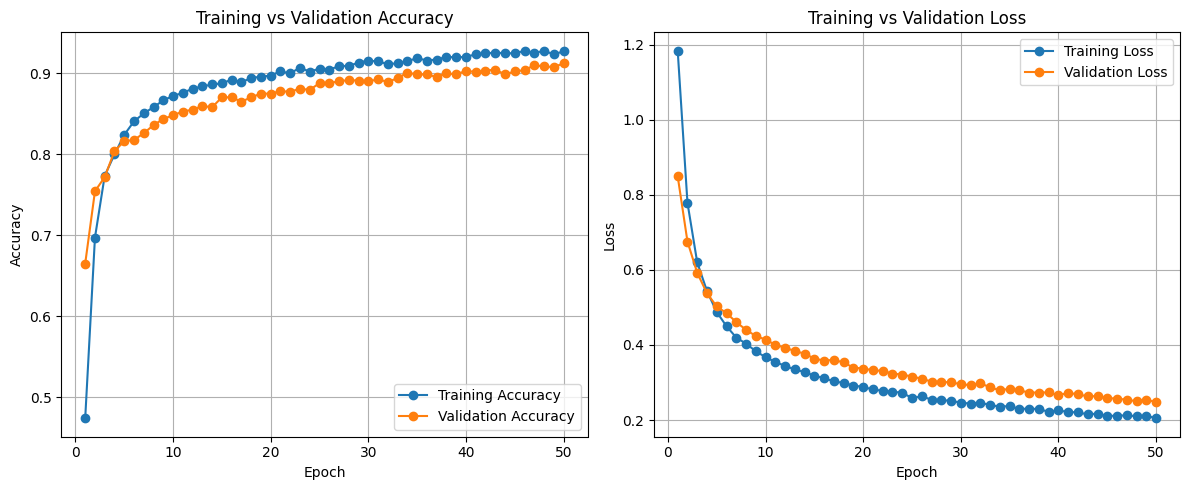

In [7]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()